# Food Reviews from Amazon

data source: https://www.kaggle.com/snap/amazon-fine-food-reviews

### Context
The dataset consists of reviews of foods from Amazon. The data span a period of more than 10 years, and about 500,000 reviews up to October 2012. 

### Contents

- row id
- ProductId: 
Unique identifier for the product
- UserId:
Unique identifier for the user
- ProfileName:
Profile name of the use
- HelpfulnessNumerator:
Number of users who found the review helpful
- HelpfulnessDenominator:
Total number of users who indicated whether they found the review helpful or not
- Score:
Rating value between 1 and 5
- Time:
Timestamp of the review
- Summary:
Title of the review
- Text:
text of the review


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.cluster import KMeans
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import homogeneity_completeness_v_measure

In [16]:
%matplotlib inline

In [2]:
path = ".\\Reviews.csv\\Reviews.csv"

In [3]:
dataset = pd.read_csv(path)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Clean data

In [5]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
dataset['ProfileName'].fillna('', inplace = True)
dataset['Summary'].fillna('', inplace = True)

In [7]:
dataset.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [7]:
dataset.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


We see how there are multiple reviews with the same:
UserId, Time, Summary, Score, Text.

For istances below we see that there are 199 reviews of the same userID, with the same title _"Filler food is empty, leaves your cat always needing more"_, with the same timestamp and review's text.
We decided to remove this duplicates, keeping only one rapresentation for those reviews having same values, in order to get unbiased results.

In order to do that, we group the data according to the specified parameters (UserId, Time, Summary, Score and Text) and select the first element of each group.

In [20]:
dataset.groupby(['UserId', "Summary", "Text","Time","Score"]).agg(counts = ('Summary','count')).sort_values(by= 'counts', ascending = False)

counts
UserId         Summary                                            Text                                               Time       Score        
A3TVZM3ZIXG8YW Filler food is empty, leaves your cat always ne... This review will make me sound really stupid, b... 1291420800 1         199
A29JUMRL1US6YP Fantastic Food for Good Cat Health                 The pet food industry can be one of the most in... 1278201600 5          45
A1UQBFCERIP7VJ Stash Chamomile Herbal Tea                         Stash Chamomile Herbal Tea is tea bags with dri... 1321401600 4          36
A29JUMRL1US6YP Fantastic Food for Good Cat Health                 The pet food industry can be one of the most in... 1278201600 5          35
A36JDIN9RAAIEC Great product, but trust your vet not the hype     I have two cats, one 6 and one 2 years old. Bot... 1292976000 5          34
...                                                                                                                                       ...
A2D6AOK65I01I8 Good value; fragrant plump beans                   I was pleased with my purchase of vanilla beans... 1338681600 5           1
A2D69HAU0NSOOH West Nile Spreader                                 The folks behind Cutter Backyard Bug Control mu... 1339718400 1           1
A2D69F8REK5ZKV Bite Sized Delight                                 They taste just like cherry Twizzlers pull-and-... 1315872000 5           1
A2D693KIFZEWTW I'M IN LOVE!!!!                                    These beans make THE best ice cream!!! I went s... 1295654400 5           1
AZZZOVIBXHGDR  Disappointed                                       I ordered this cereal based on the good reviews... 1333497600 2           1

[395159 rows x 1 columns]

In [8]:
df = dataset.groupby(['UserId', "Summary", "Text","Time","Score"]).nth(0)

In [9]:
df.size

1975795

In [10]:
df = df.reset_index()

Let's check that there are no more duplicates:

In [11]:
df.groupby(['UserId', "Summary", "Text","Time","Score"]).agg(counts = ('Summary','count')).sort_values(by= 'counts', ascending = False)

counts
UserId             Summary                             Text                                               Time       Score        
#oc-R103C0QSV1DF5E Great for the Price                 I have to say I was a little apprehensive to bu... 1343088000 5           1
A3ITWZ85QT9UY2     FRESH!!!!!                          Love this order!<br />The nuts are Fresh!<br />... 1301529600 5           1
A3IUV4W3EODNJX     Cocktail                            One of the best margarita mixes I ever had. The... 1333756800 5           1
A3IUUPDUZVGZKN     Too lazy to pick your own cherries? Then get this. This has to be the best canned f... 1292630400 5           1
A3IUTZ9WWBG8FI     Great Way to Entertain Your Dog     Our Jack Russell is a real chow hound and just ... 1246233600 5           1
...                                                                                                                            ...
A29P51TN9KKMU9     Surprisingly good!                  I was lucky to be given a sample of this matcha... 1345248000 5           1
                   Such a good smooth vanilla!         This here is so good its not an "in your face" ... 1345161600 5           1
                   Strawberry Heaven!                  You know this matcha screams summer and while I... 1345593600 5           1
                   So so so so so so good!             This is so delicious! Truly a taste sensation. ... 1346284800 5           1
AZZZOVIBXHGDR      Disappointed                        I ordered this cereal based on the good reviews... 1333497600 2           1

[395159 rows x 1 columns]

In [12]:
dataset.UserId.nunique()

256059

In [13]:
df.UserId.nunique()

256059

# Text prepocessing

In order to select only the important words from text we:

- convert all the word in lowercase
- remove html tags
- remove stop words and punctuation
- remove alphanumeric word

Belove we see an example of removal of html tags from a text:

In [15]:
print("Before:")
df.loc[395158, 'Text']

Before:


'I ordered this cereal based on the good reviews here and else where on the web. I also have tried and love the <a href="http://www.amazon.com/gp/product/B001EQ56E4">Envirokidz Organic Leapin\' Lemurs Peanut Butter & Chocolate Cereal, 10-Ounce Boxes (Pack of 6)</a>. Unfortunately the frosted flakes taste nothing like it\'s standard counterpart. The flakes are hard, but not crisp. They are also very lightly sweetened.<br /><br />This is the one environkids cereal that I couldn\'t find locally, and now I see why. Overall I feel like this was a waste of money.'

In [17]:
print("After:")
re.sub("<.*?>",'', df.loc[395158, 'Text'])

After:


"I ordered this cereal based on the good reviews here and else where on the web. I also have tried and love the Envirokidz Organic Leapin' Lemurs Peanut Butter & Chocolate Cereal, 10-Ounce Boxes (Pack of 6). Unfortunately the frosted flakes taste nothing like it's standard counterpart. The flakes are hard, but not crisp. They are also very lightly sweetened.This is the one environkids cereal that I couldn't find locally, and now I see why. Overall I feel like this was a waste of money."

In [18]:
def remove_tag(text):
    """ remove html tag and the content between angle brakets < > """
    return re.sub("<.*?>",'', text)    

In [19]:
#get the set of stop word from the library 
stop_words = set(stopwords.words('english'))

In [21]:
#complete the set of stop words by reading from file
with open("stop_words.txt", 'r') as f:
    other_stop_words = [line.rstrip() for line in f]

stop_words.update(other_stop_words) #add new stop words to the set

In [22]:
def remove_stop_word(phrases):
    """checks for each word if it is contained 
    in the set of stop words and return only 
    no stop words in lower case"""
    tokenizer = RegexpTokenizer(r'[a-z]+')
    word = tokenizer.tokenize(phrases.lower())
    important_word = [w for w in word if w not in stop_words]
    return ' '.join(important_word)

In [23]:
df['Text'] = df.apply(lambda x : remove_tag(x['Text']), axis=1)

In [24]:
df['words'] = df.apply(lambda x : remove_stop_word(x['Text']), axis=1)

After removing tags a nd stop words,
below we can see orginal text vs important words.

In [26]:
with pd.option_context('display.max_colwidth', None):
  display(df[['Text','words']])

,Text,words
0,"I have to say I was a little apprehensive to buy this product for the price, but I like to keep my K-Cup price under $0.50 and Sam's Club was sold out at the time, and I tried this. The Fuhgeddaboudit is very strong, but that's how I like it. Overall, I was impressed.",apprehensive buy product price keep cup price sam club sold time fuhgeddaboudit strong impressed
1,Received my free K cups as a sample promotion and LOVE them. I have at least one a day at work!!!!,received free cups sample promotion love day work
2,"Brooklyn Bean Roastery Blend K-Cups are great tasting coffee. I like the Breakfast blend flavor the best, it is light tasting and it surprised me how fast it wakes you up. The dark roasts Fudgeddaboutit and Cyclone have a stronger rich flavor. I think the donut shop and maple flavor is sweet flavored and light which is good in coffee. The Brooklyn Bridge is a good well balanced coffee. I think the Breakfast Blend flavor is the best flavor and it wakes you up quickly.",brooklyn bean roastery blend cups great tasting coffee breakfast blend flavor best light tasting surprised fast wakes dark roasts fudgeddaboutit cyclone stronger rich flavor donut shop maple flavor sweet flavored light good coffee brooklyn bridge good well balanced coffee breakfast blend flavor best flavor wakes
3,"The shipment of the dog food was quick. However, when I opened the main box which contained several smaller containers, there was an awful smell which I discovered was a busted can of dog food. Other than that the product was as expected.",shipment dog food quick opened main box contained smaller containers awful smell discovered busted dog food product expected
4,"Brooklyn ""French Roast"" K-Cup Coffee is not one of my favorites. It's not awful. It's okay if you're in a ""pinch"" and it's the only pod you have. I ended up giving my entire box to a friend. I wasn't a fan. There was nothing special or memorable about the taste. I won't buy it again and I won't recommend it.",brooklyn french roast cup coffee favorites awful pinch pod ended entire box friend fan special memorable taste buy recommend
...,...,...
395154,I love this syrup. It is my personal substitute for the Bailey's Irish Cream Syrup (non-alcoholic) that is hard to find. And I love that I can order a 3-pack to automatically ship when I need it. Just wish there was a 3-pack variety pack. But I'll take this-I don't make a cup of coffee without it.,love syrup personal substitute bailey irish cream syrup alcoholic hard find love order pack automatically ship pack variety pack cup coffee
395155,"i've wanted one of these since i saw it in an overpriced kitchen store last summer. i don't seem to have any luck growing herbs from seed and keeping them alive. this neat little machine had the seeds started in no time at all. some of the plants grow faster than others, but i've just been trimming them down to let others catch up. working very well so far! i find it wonderful to have fresh herbs at hand in the winter. i just set it up less than four weeks ago and i already got to use my basil. the only thing is to set the light timer to go off around bed time. it is incredibly bright!!",wanted overpriced kitchen store summer luck growing herbs seed keeping alive neat machine seeds started time plants grow faster trimming catch working well find wonderful fresh herbs hand winter set weeks ago basil thing set light timer bed time incredibly bright
395156,All of the chocolate arrived with out melting an not broken in peices. The taste is supreme and melts just right. This is a 2 Quantity buy because 1 is not enough. Starting with the Assortment which will make the best impression on the taste buds.,chocolate arrived melting broken peices taste supreme melts quantity buy starting assortment best impression taste buds
395157,"I use this all the time! Good for BBQ ing or pan fry, what ever you want and it goes! Even for fajitas! It's just a rich flavor that reminds me of mexico!! Go

In [31]:
#save
df.to_csv("C:\\Users\\Alessandra\\Desktop\\LAB_AMD\\HW4\\cleaned.csv")

In [53]:
#load
df = pd.read_csv("C:\\Users\\Alessandra\\Desktop\\LAB_AMD\\HW4\\cleaned.csv", index_col=None)

In [54]:
df.drop("Unnamed: 0", axis=1, inplace = True)

In [55]:
df.dropna(inplace = True)

## Inverted Index

We build an inverted index that will be useful later.
The inverted index would be a dictonary that maps each word present in the text of a review to the set of indeces (of the dataframe) that contain that word. 
We save our dictonary in a json file in order to load it later.

In [89]:
ds = df["words"].to_frame()

In [91]:
ds.head(3)

,words
0,apprehensive buy product price keep cup price ...
1,received free cups sample promotion love day work
2,brooklyn bean roastery blend cups great tastin...


In [111]:
ds['list_of_words'] = list(map(lambda x: x.split(),ds['words'].values))
ds = ds['list_of_words'].to_frame()

In [112]:
ds.head(1)

,list_of_words
0,"[apprehensive, buy, product, price, keep, cup,..."


In [113]:
ds = ds.explode(column = 'list_of_words') 
dt = ds.reset_index()

In [160]:
dt.head(10)

,index,list_of_words
0,0,apprehensive
1,0,buy
2,0,product
3,0,price
4,0,keep
5,0,cup
6,0,price
7,0,sam
8,0,club
9,0,sold


In [161]:
dt.groupby('list_of_words')['index'].apply(set)

list_of_words
aaaaaa                                        {83081, 383130}
aaaaaaaaaa                                            {24716}
aaaaaaaaaaa                                          {207931}
aaaaaaaaaaaa                                         {281797}
aaaaaaaaaaaaa                                        {388581}
                                                   ...       
zzzzzzz                                      {112616, 104430}
zzzzzzzz                                             {132697}
zzzzzzzzzz                                           {336984}
zzzzzzzzzzz                                             {812}
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz            {262644}
Name: index, Length: 124212, dtype: object

In [164]:
# create the dictonary word:[list of indeces]
# .apply(set) deletes duplicates indeces refers to the same word, 
#that is when a word is contained many times in the same row (avoid item in dictonary like word : [doc1, doc1,doc2])
inverted_index = dt.groupby('list_of_words')['index'].apply(set).apply(list).to_dict()

For istance, let's see 3 items of our inverted index:

In [165]:
keys = list(inverted_index.keys())
for k in keys[507:510]:
    print(k,':', inverted_index[k])

acceptably : [143969, 98436, 67948, 178608, 92849, 269489, 300274, 317843, 333394, 359736, 15486]
acceptalble : [301666]
acceptale : [24024]


In [166]:
#save on file
import json
with open('inverted_index.json', 'w') as fp:
    json.dump(inverted_index, fp)

In [65]:
#load the file 
import json
with open('inverted_index.json','r') as fp:
    inverted_index = json.load(fp)

# TD IDF and Dimension Reduction

We focus our analysis to the text of the reviews. We decided to rapresent the data like vectors where each item is the value of the TD IDF of a specific word. The TD IDF is a measure of importance of a word in a set of documents.

Since there too many words in our vocabulary (over 50 thousand) we reduce the dimensionality of our dataset using the SVD methods. 
To decide the final number of features:
we try different reductions by increasing the number of components each time and keeping track of the sum of variance explained by selected components. We graphically represent the relationship between the number of selected components and variance explained, and in we selected a number of componets that retain about the 70 % of the variance.

In [51]:
vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

In [56]:
t0 = time()
X = vectorizer.fit_transform(df['words'])
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 15.459114s
n_samples: 395139, n_features: 58446



In [44]:
type(X)

scipy.sparse.csr.csr_matrix

In [63]:
print("Performing dimensionality reduction using LSA")
print()

n_components = [10,1000,2000,3000,3500] # list containing different values of components
explained_variance = [] # explained variance ratio for each component of Truncated SVD

for i in tqdm(range(len(n_components))):
    svd = TruncatedSVD(n_components[i])
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    fit = lsa.fit_transform(X)
    variance = svd.explained_variance_ratio_.sum()
    explained_variance.append(variance)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Performing dimensionality reduction using LSA




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:09:59<00:00, 2279.92s/it]


Number of components: 10 and explained variance: 0.04 
Number of components: 1000 and explained variance: 0.53 
Number of components: 2000 and explained variance: 0.67 
Number of components: 3000 and explained variance: 0.74 
Number of components: 3500 and explained variance: 0.77 



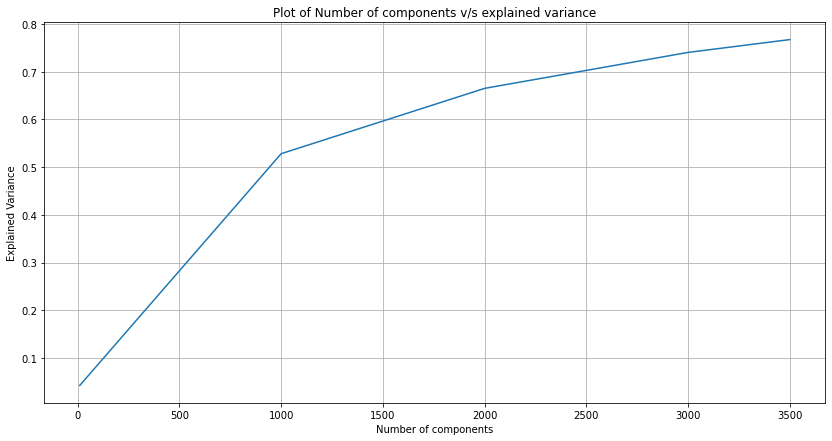

In [89]:
for i in range(len(n_components)):
    print("Number of components: %r and explained variance: %r "%(n_components[i],round(explained_variance[i],2)))
print()
fig = plt.figure(figsize=(14,7))
plt.plot(n_components, explained_variance)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.grid()
plt.show()

We choose 2000 feautures that explain 67% of the variance.

In [59]:
t0 = time()
svd = TruncatedSVD(2000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
fit = lsa.fit_transform(X)
print("done in %fs" %(time()-t0))

done in 1113.054714s


In [10]:
import pickle

In [36]:
with open('TruncatedSVD2000', 'wb') as f:
    pickle.dump(fit, f)

In [13]:
#to load
with open('TruncatedSVD2000', 'rb') as f:
    fit = pickle.load(f)

# 2 Clustering

In this section we focus our attention on the text of reviews and cluster the products. 

We to separate n samples in k groups with k-means clustering method. 

The k-means algorithm divides the set of samples into disjoint clusters, each described by the mean
of the samples in the cluster, commonly called the cluster “centroids”. 
The algorithm aims to choose centroids that minimise the inertia, that is the sum of squared distances of samples to their closest cluster center.

In particular:

- we implement KMeans clustering algorithm from scratch. 
- we confront our KMeans with KMeans provided by sklearn library

KMeans requires the number of clusters to be specified.<br>
In order to select the number of clusters, we use the **Elbow Method:** the method consists in running KMeans on the dataset for different value of number of clusters K, plot the inertia in relationship with K, and looking for the point of inflection on the curve, that is where inertia stops decreasing significantly.

In [134]:
elbow = {}
for k in tqdm(range(2,38,4)):
    kmodel = KMeans(k, init = "k-means++", max_iter=100)
    kmodel.fit(fit)
    kmodel.predict(fit)
    elbow[k] = kmodel.inertia_

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [46:03<00:00, 552.71s/it]


In [8]:
elbow

{2: 383012.8356268572,
 6: 374733.75910380593,
 10: 370890.4395630731,
 14: 367791.2851669607,
 18: 365241.82508559496,
 20: 363982.0028579253,
 28: 359309.03330510296,
 32: 357830.20350158395,
 36: 355597.969490552}

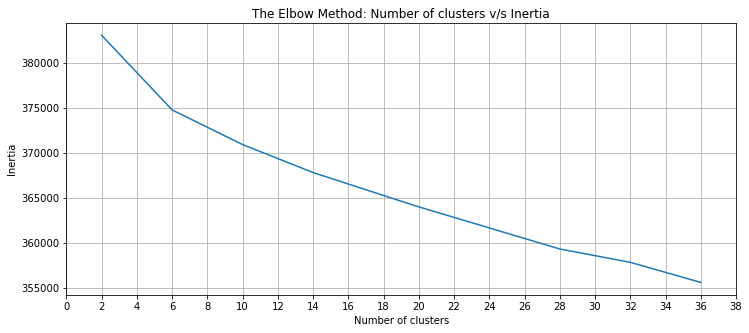

In [11]:
fig = plt.figure(figsize=(12,5))
plt.plot(list(elbow.keys()), list(elbow.values())) 
plt.xlabel('Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method: Number of clusters v/s Inertia') 
plt.grid()
plt.xticks(np.arange(0, 40, step=2))
plt.show() 

From the elbow method visible in the graph above, we choose 28 as number of clusters.

Below we run our KMeans algorithm:

In [19]:
class k_means:
    
    def __init__(self, data, num_centroids, max_iterations = 3):
        self.iterations = 0
        self.data = data 
        self.max_iterations = max_iterations 
        

        self.num_centroids = num_centroids
        self.num_training_data = data.shape[0] # 
        self.num_features = data.shape[1]

        self.centroids = self.get_random_centroids()
        self.old_centroids = np.zeros(self.centroids.shape)

        self.labels = np.zeros(self.num_training_data)
        self.distances = np.zeros((self.num_training_data,self.num_centroids))

    def get_random_centroids(self):
        mean = np.mean(self.data, axis = 0)
        std = np.std(self.data, axis = 0)
        return np.random.randn(self.num_centroids,self.num_features)*std + mean

    def kmeans(self):
        while not self.should_stop():
            self.iterations += 1
            self.old_centroids = self.centroids.copy()
            self.get_labels()
            self.get_new_centroids()
        return self.centroids

    def should_stop(self):
        if self.iterations > self.max_iterations: 
            return True
        return (self.old_centroids == self.centroids).all()

    def get_labels(self):
        self.labels = np.apply_along_axis(lambda x: np.argmin(np.sqrt(np.sum((self.centroids - x)**2, axis=1))), 1, self.data)

    def get_new_centroids(self):
        for i in range(self.num_centroids):
            self.centroids[i] = (self.data[self.labels == i].mean(axis = 0))

In [ ]:
num_of_cluster = 28

In [21]:
#clustering with our KMeans
t0 = time()
my_k_means= k_means(fit, num_centroids = num_of_cluster, max_iterations = 700)
myKMeans = my_k_means.kmeans()

Now let's run KMeans provides by library sklearn and confront with our algorithm:

In [ ]:
#clustering with our KMeans
t0 = time()
my_k_means= k_means(fit, num_centroids = 28, max_iterations = 700)
myKMeans = my_k_means.kmeans()

In [ ]:
#clustering with sklearn
kmodel = KMeans(num_of_cluster, init = "k-means++", max_iter=100)
kmodel.fit(fit)
kmodel.predict(fit)

Now we are interested in evaluating the performance of a clustering algorithm, that is not a trivial task, in fact any evaluation metric should not take the absolute values of the cluster labels. For this puropose we use the **Rand score**, a measure of **similarity** between two clustering, ignoring permulations. The scrore goes from 0 to 1, where perfect labeling is scored 1.0

In [30]:
my_k_means.labels

array([11,  6,  5, ..., 15, 27,  1], dtype=int64)

In [33]:
kmodel.labels_

array([27,  5,  1, ..., 25, 27, 21])

The value of Rand score is: 0.90

In [46]:
round(rand_score(kmodel.labels_,my_k_means.labels),3)

0.902

Below we see the _Homogeneity_, _completeness_ and _V-measure_ between the assignmets of our algorithm vs sklearn:

In [45]:
tuple(map(lambda x : round(x,3),homogeneity_completeness_v_measure(kmodel.labels_,my_k_means.labels)))

(0.604, 0.604, 0.604)

## 2.3 Analysis of Cluster
- Identify the kind of products in the cluster using a visualization called word cloud.
- number of product in each cluster
- reviews' score distribution in each cluster.
- number of unique users writing reviews in each cluster

### 2.3.1 Identify the kind of products in the cluster using a visualization called word cloud.

From the elbow method visible in the graph above, we choose 14 as number of clusters.

For clarity of presentation, we will show, for each cluster, the 10 most important words.

Then we build a dictonary that maps the number of the cluster with the 10 words cointained in it.

In [18]:
from wordcloud import WordCloud

In [57]:
def wordcloud(clustered_dic):
    for x in range(len(clustered_dic)):        
        print("For cluster %r" % x)
        clustered = ' '.join(clustered_dic[x])
        wordcloud_positive_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10)\
        .generate(clustered) 
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud_positive_words)
        plt.title("Word Cloud for cluster %r using Kmeans clustering"%x)
        plt.axis('off')
        plt.show()          

In [60]:
original_space_centroids = svd.inverse_transform(kmodel.cluster_centers_)

In [61]:
order_centroids = original_space_centroids.argsort()[:, :: -1]

In [62]:
terms = vectorizer.get_feature_names()

In [63]:
clustered_words = {}
for i in range(num_of_cluster):
        clustered_words[i] = []
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]: #first 10 terms of each cluster, #1000 for full cluster
            clustered_words[i].append(terms[ind])
            print(' %s' % terms[ind], end='')
        print()

Cluster 0: product good great taste buy price love recommend amazon excellent
Cluster 1: coffee flavor good taste cup strong great love best drink
Cluster 2: rice brown good great chicken flavor taste love cook cooker
Cluster 3: pasta cheese mac good taste sauce noodles great wheat love
Cluster 4: food dog dogs eat loves dry foods feed love good
Cluster 5: good taste flavor love best salt buy better eat bought
Cluster 6: bars bar snack chocolate granola taste protein good great eat
Cluster 7: drink energy juice taste drinks flavor soda good day sweet
Cluster 8: candy candies good great hard love taste box bar sweet
Cluster 9: amazon price store grocery local stores buy good shipping love
Cluster 10: gum hair shampoo conditioner scalp product flavor long good clear
Cluster 11: dog treats dogs treat loves love chew teeth toy small
Cluster 12: oil coconut olive great good cooking popcorn product skin taste
Cluster 13: sugar free taste sweet good syrup product great flavor love
Cluster 14:

For cluster 0


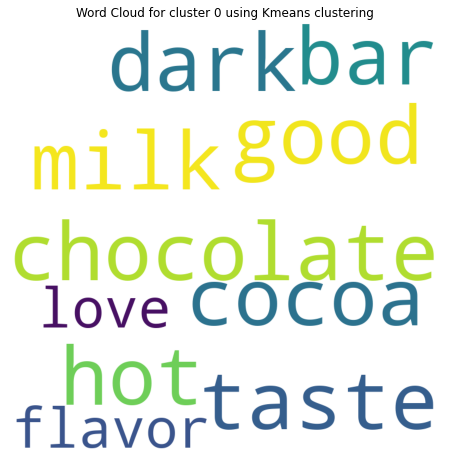

For cluster 1


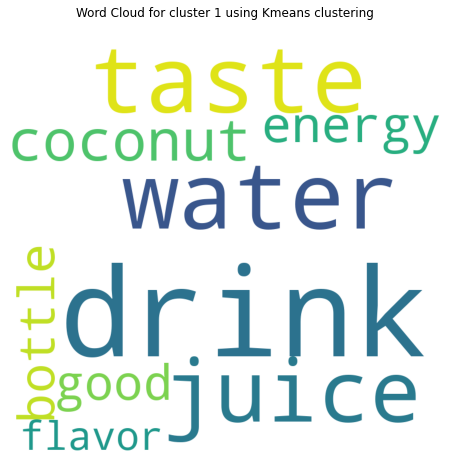

For cluster 2


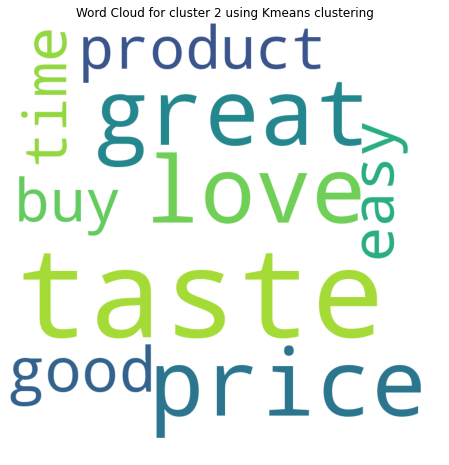

For cluster 3


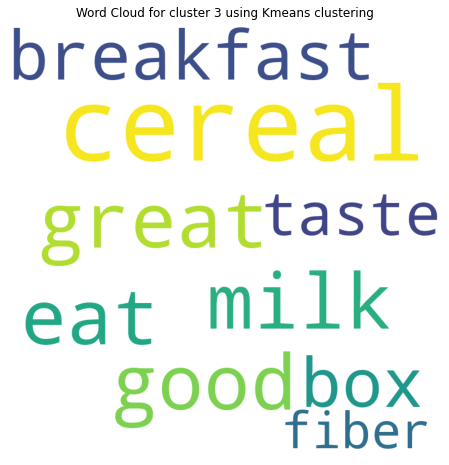

For cluster 4


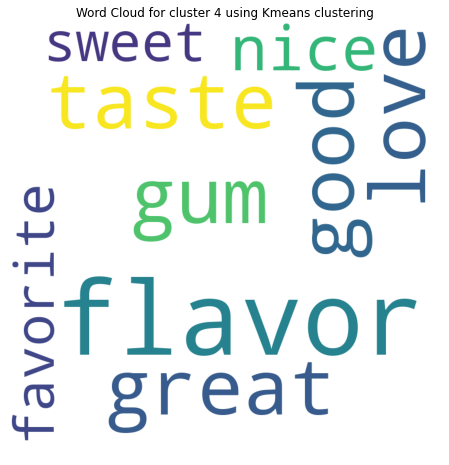

For cluster 5


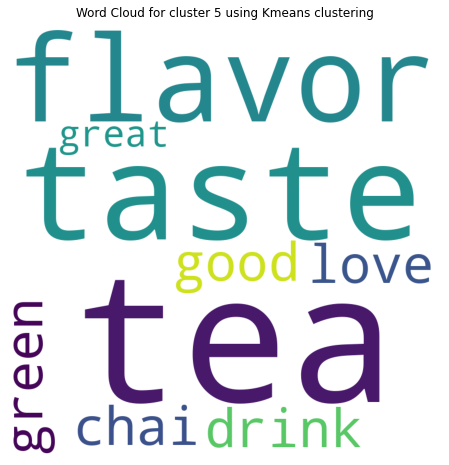

For cluster 6


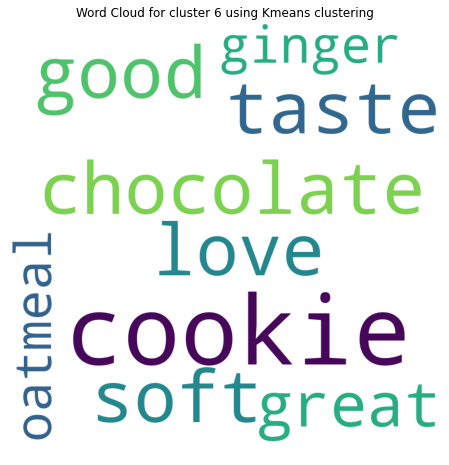

For cluster 7


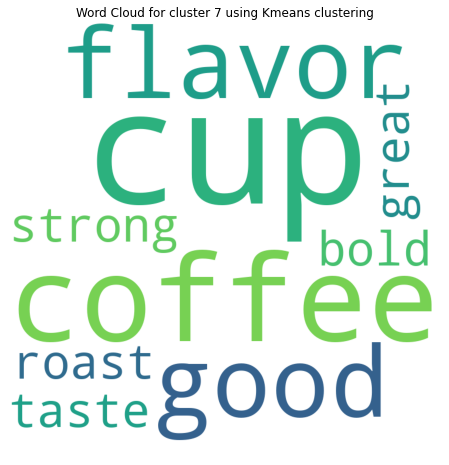

For cluster 8


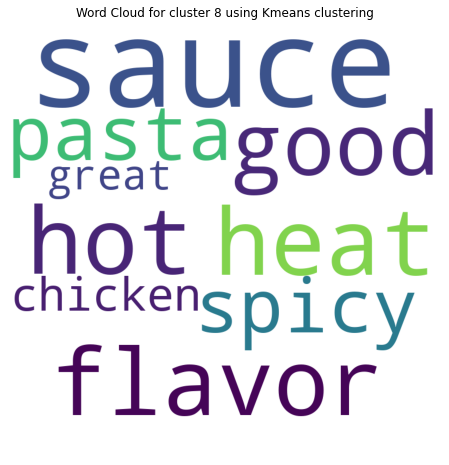

For cluster 9


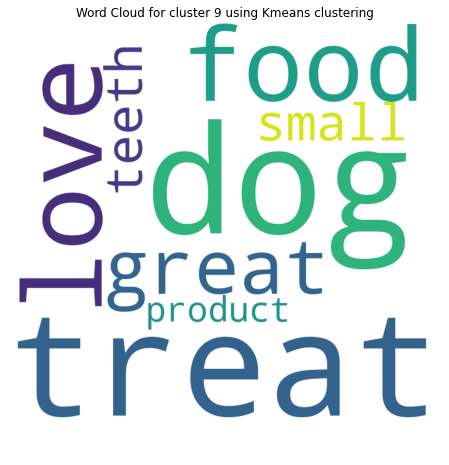

For cluster 10


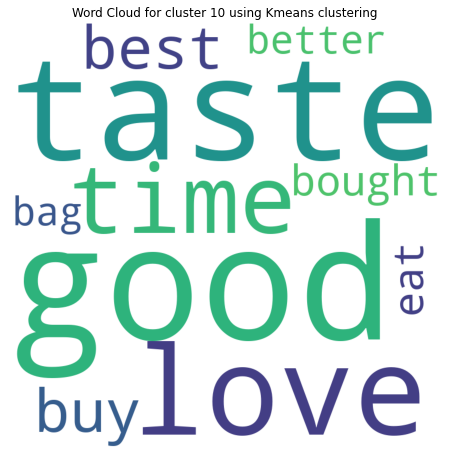

For cluster 11


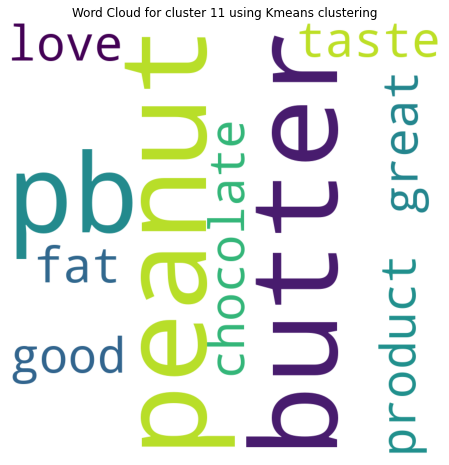

For cluster 12


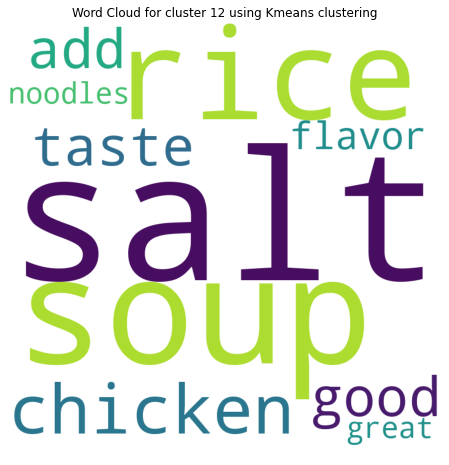

For cluster 13


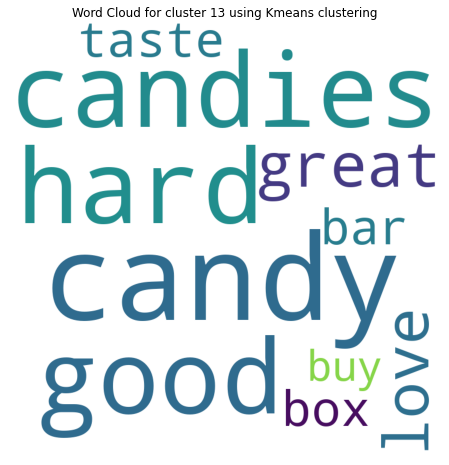

For cluster 14


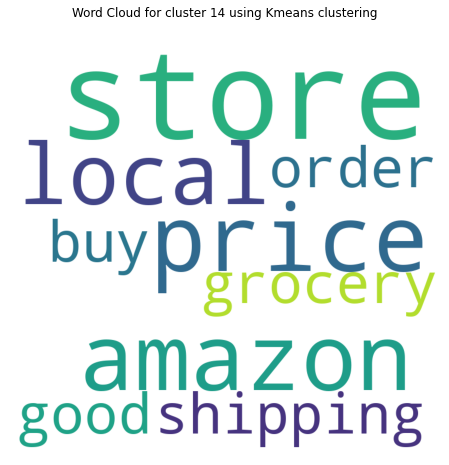

For cluster 15


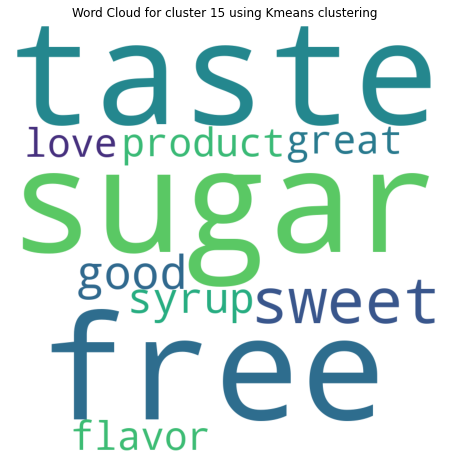

For cluster 16


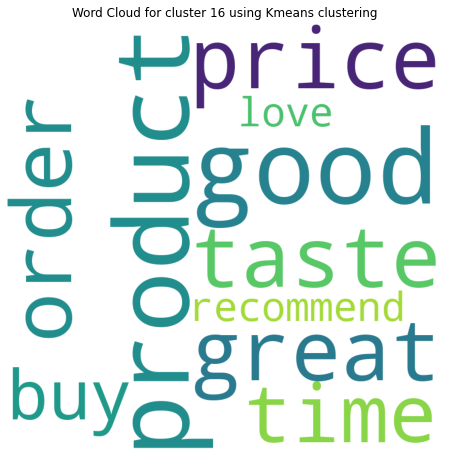

For cluster 17


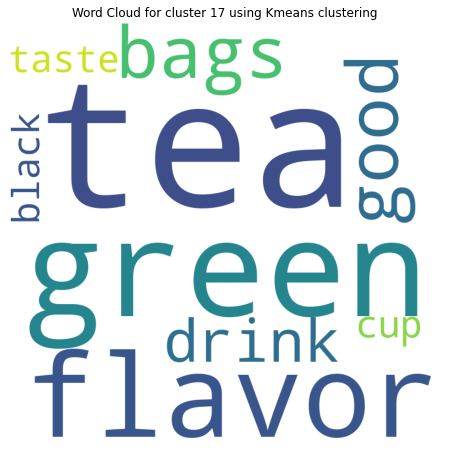

For cluster 18


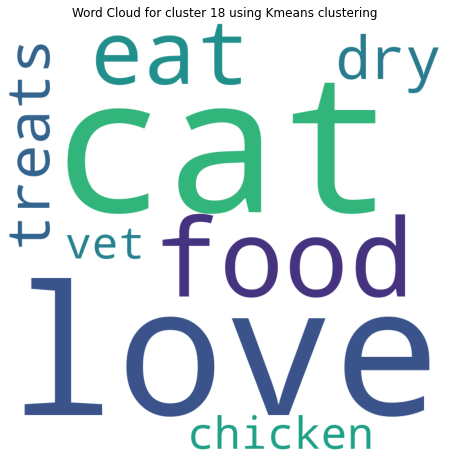

For cluster 19


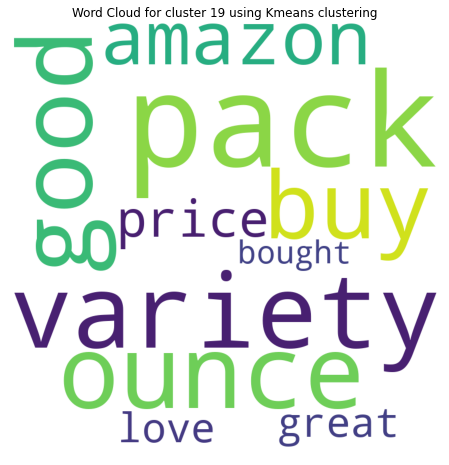

For cluster 20


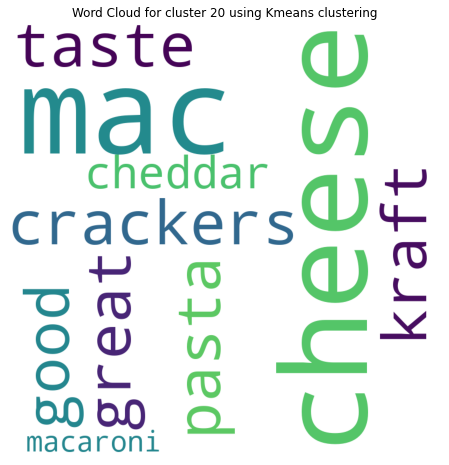

For cluster 21


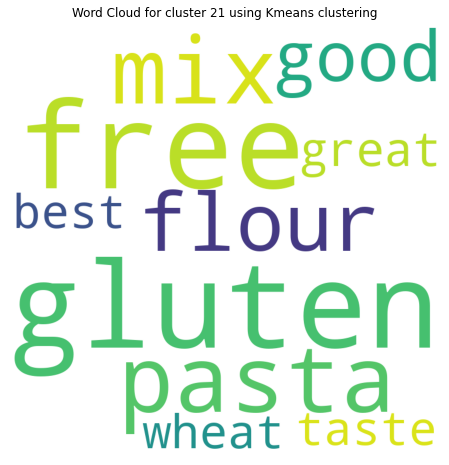

For cluster 22


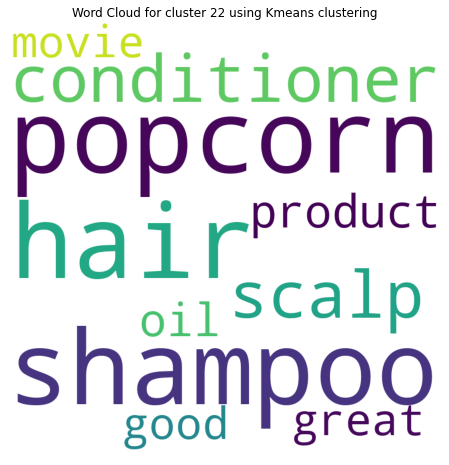

For cluster 23


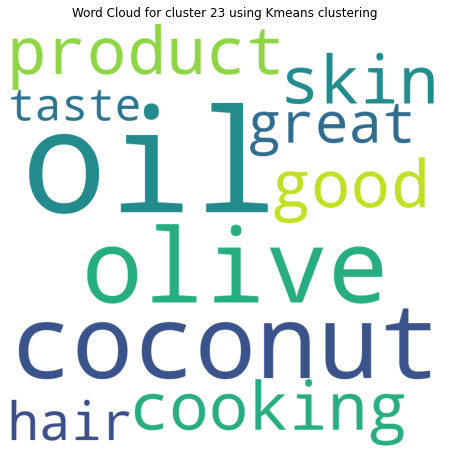

For cluster 24


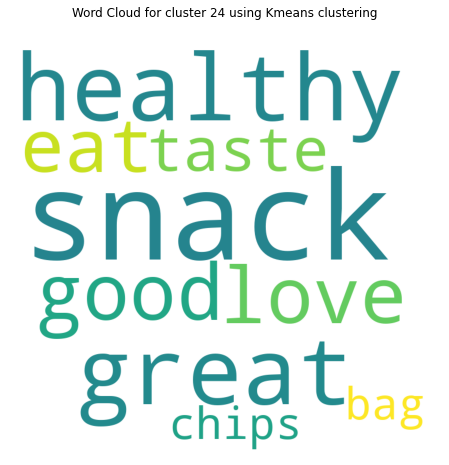

For cluster 25


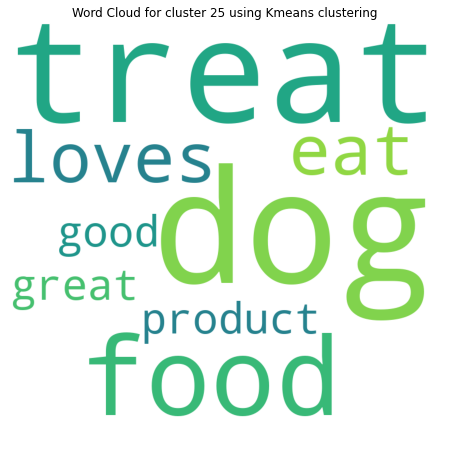

For cluster 26


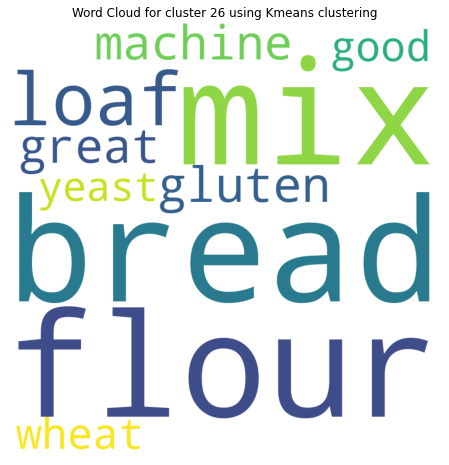

For cluster 27


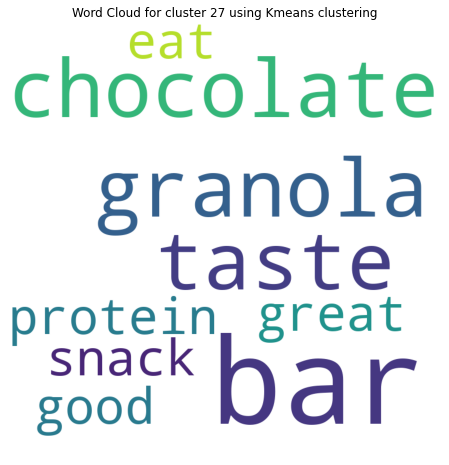

In [28]:
wordcloud(clustered_words)

### 2.3.2 Provide the number of product in each cluster

For retrieving the products relates to each word of the cluster, we will use the inverted index build before. This inverted index is a dictonary where the keys set is given by all the sigle word present in the dataset and the values are indeces of the reviews that contains the word.

Let's see for instances the indeces of the dataset of the reviews that contains the word "sweet", using indeces we retrieve its reviews:

In [51]:
#how many reviews cotains the word sweet
len(inverted_index["sweet"])
inverted_index["sweet"][:8]

[262144, 393217, 2, 393220, 262154, 131090, 131092, 131094]

In [189]:
#one of the review of the word "sweet"
df.loc[131094, "Text"]

"I love this granola. I eat it for breakfast with yogurt, with milk (which isn't as good) or by itself as a snack. It's really tasty. Sweet without being too sweet.  The only thing one might not like about it is that it is sticky.It is a great deal too - cheaper than what I found in stores."

Hence the main step are:

1) Retrieve for each cluster the set of reviews (in particular the indeces of the dataframe), and save them in a dictonary.

2) For each review get the set of products.


In [66]:
#1 build a dictonary that maps cluster to set of indeces 
clust_reviewID = {}
for k in clustered_words.keys():
    set_of_review = set()
    for w in clustered_words[k]:
        set_of_review.update(inverted_index[w])
    clust_reviewID[k] = list(set_of_review)

In [30]:
def get_num_product_per_cluster(df, clust_reviewID):
    num_product_per_cluster = []
    for k in clust_reviewID:
        set_of_product = set()
        for review in clust_reviewID[k]:
            set_of_product.update([df.loc[review, "ProductId"]])
        num_product_per_cluster.append(len(set_of_product))
    return num_product_per_cluster   

In [31]:
def visualize_prod_per_cluster(df, clust_reviewID, clustered_words):
    product_per_cluster =get_num_product_per_cluster(df, clust_reviewID)
    new_dict = {}
    new_dict['cluster'] = list(clustered_words.keys())
    new_dict['words'] = [' '.join(lista) for lista in clustered_words.values()]
    new_dict['number of products'] = product_per_cluster
    return pd.DataFrame.from_dict(new_dict).set_index("cluster")

In [32]:
with pd.option_context('display.max_colwidth', None):
    display(visualize_prod_per_cluster(df, clust_reviewID,clustered_words))

,words,number of products
cluster,,
0,chocolate dark milk hot taste cocoa good bar flavor love,53428
1,water drink taste juice coconut energy bottle drinks good flavor,49831
2,great taste price love good product tastes buy easy time,60249
3,cereal milk cereals good great eat breakfast box taste fiber,53057
4,flavor gum good taste great love flavors nice sweet favorite,57560
5,tea teas taste flavor good drink green love chai great,56425
6,cookies cookie chocolate taste good soft love great ginger oatmeal,54588
7,coffee cup good flavor strong taste roast cups great bold,54031
8,sauce hot sauces flavor heat good pasta spicy chicken great,51831


### 2.3.3 Compute the reviews' score distribution in each cluster

In [33]:
import seaborn as sns 

In [34]:
sns.__version__

'0.11.0'

In [35]:
clust_scoreList = {}
for k in clustered_words.keys():
    list_of_score = []
    for w in clustered_words[k]:
        list_of_score.append([df.loc[review, "Score"] for review in inverted_index[w]])
    clust_scoreList[k] = list_of_score

In [36]:
clust_score_dict = {}
clust_score_dict['cluster'] = list(clustered_words.keys())
clust_score_dict['score'] = list(clust_scoreList.values())
scores_clust_df = pd.DataFrame.from_dict(clust_score_dict).set_index("cluster")

In [37]:
with pd.option_context('display.max_colwidth', None):
    display(scores_clust_df)

,score
cluster,
0,"[[1, 2, 5, 5, 4, 1, 5, 5, 5, 5, 5, 4, 1, 5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 2, 1, 5, 5, 5, 2, 5, 5, 3, 5, 5, 1, 5, 5, 1, 5, 3, 4, 4, 5, 5, 2, 4, 4, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 3, 4, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 5, 2, 5, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, ...], [5, 5, 4, 5, 2, 4, 1, 5, 3, 5, 3, 4, 5, 5, 5, 4, 5, 5, 5, 5, 3, 5, 5, 4, 4, 5, 5, 3, 4, 4, 1, 5, 4, 1, 5, 4, 5, 5, 4, 5, 5, 5, 2, 4, 4, 4, 5, 3, 5, 3, 4, 5, 5, 2, 5, 3, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 4, 4, 1, 5, 5, 4, 2, 5, 3, 2, 3, 5, 5, 1, 4, 5, 5, 5, 4, 1, 5, 5, 3, 4, 5, 4, 5, 5, 5, 1, 2, 5, 4, 5, ...], [1, 5, 2, 4, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 3, 1, 1, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 1, 5, 5, 4, 3, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 1, 5, 4, 5, 5, 5, 5, 3, 5, 5, 4, 5, 3, 4, 5, 5, 5, 5, 5, 1, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 3, 5, 5, 5, ...], [4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 2, 5, 2, 1, 4, 1, 1, 5, 5, 5, 2, 5, 5, 3, 5, 4, 1, 4, 5, 5, 3, 5, 5, 4, 5, 2, 5, 5, 4, 5, 4, 4, 5, 2, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 2, 5, 4, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, ...], [4, 1, 5, 4, 3, 5, 3, 5, 4, 4, 2, 5, 1, 5, 3, 5, 5, 1, 3, 5, 5, 1, 1, 1, 5, 4, 5, 5, 1, 2, 5, 5, 4, 5, 1, 2, 5, 5, 5, 2, 5, 1, 5, 5, 4, 1, 5, 5, 3, 4, 5, 3, 2, 1, 3, 1, 5, 2, 5, 5, 5, 5, 1, 2, 2, 1, 1, 4, 1, 1, 3, 4, 5, 2, 5, 5, 5, 5, 1, 5, 5, 2, 1, 5, 2, 5, 2, 3, 2, 5, 5, 1, 2, 5, 5, 1, 5, 2, 1, 5, ...], [5, 5, 5, 1, 2, 5, 2, 5, 4, 4, 3, 5, 5, 5, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 2, 5, 5, 2, 3, 1, 4, 5, 4, 5, 3, 4, 4, 5, 4, 1, 5, 4, 1, 3, 5, 4, 5, 5, 5, 5, 5, 4, 4, 1, 5, 5, 5, 5, 5, 3, 2, 4, 3, 5, 5, 3, 3, 5, 3, 5, 5, 5, 1, 5, 5, 5, 2, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 4, 4, 4, 5, 1, ...], [4, 4, 5, 5, 5, 2, 4, 5, 4, 5, 2, 4, 3, 1, 5, 1, 5, 5, 5, 3, 4, 5, 5, 5, 3, 5, 1, 1, 1, 1, 3, 3, 3, 5, 1, 3, 4, 5, 1, 2, 5, 5, 3, 5, 2, 4, 3, 5, 2, 1, 5, 5, 4, 5, 5, 4, 5, 3, 1, 4, 2, 1, 3, 5, 5, 5, 4, 2, 5, 1, 4, 1, 4, 3, 5, 3, 4, 3, 4, 1, 5, 3, 1, 5, 5, 1, 5, 5, 5, 5, 1, 3, 5, 2, 1, 5, 2, 5, 4, 1, ...], [5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 4, 5, 4, 5, 1, 5, 5, 5, 5, 3, 3, 5, 4, 3, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 5, 3, 5, 4, 4, 5, 4, 4, 5, 5, 5, 4, 5, 5, 2, 3, 5, 3, 5, 4, 4, 1, 1, 1, 5, 4, 5, 4, 5, 5, 5, 3, 5, 4, 5, 5, 5, 5, 1, 4, 1, 5, 5, 4, 1, 4, 5, 3, 3, 4, 4, 5, 5, 5, 3, 5, 5, 5, ...], [4, 1, 5, 2, 1, 2, 5, 3, 2, 5, 5, 2, 5, 2, 4, 5, 1, 5, 3, 3, 4, 5, 1, 5, 1, 5, 5, 4, 5, 5, 5, 1, 4, 5, 4, 3, 5, 2, 5, 5, 5, 2, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 1, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 1, 1, 4, 5, 5, 5, 1, 2, 2, 5, 3, 5, 5, 5, 5, 1, 2, 5, 5, 5, 5, 3, 5, 3, 1, ...], [5, 5, 1, 4, 1, 1, 1, 5, 3, 4, 5, 3, 1, 5, 3, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 1, 3, 2, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 2, 3, 1, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 3, 5, 5, ...]]"
1,"[[4, 2, 5, 5, 3, 5, 2, 5, 1, 4, 1, 5, 2, 1, 5, 5, 5, 5, 5, 5, 1, 2, 1, 5, 5, 5, 4, 4, 5, 3, 5, 5, 4, 5, 2, 1, 2, 1, 4, 5, 5, 3, 4, 3, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1, 4, 5, 1, 3, 5, 5, 5, 5, 5, 4, 5, 3, 2, 5, 3, 1, 5, 5, 5, 5, 1, 5, 2, 4, 5, 5, 1, 5, 1, 5, 3, 3, 5, 5, 4, 1, 4, 5, 5, 4, 4, 5, 5, ...], [2, 5, 5, 5, 5, 5, 4, 5, 5, 5, 2, 5, 5, 2, 2, 5, 5, 1, 5, 5, 5, 3, 4, 3, 5, 4, 5, 5, 3, 5, 4, 2, 3, 3, 3, 1, 5, 1, 5, 5, 5, 1, 5, 2, 5, 5, 4, 5, 4, 5, 1, 5, 2, 5, 4, 5, 5, 5, 5, 3, 5, 2, 2, 4, 5, 4, 2, 5, 1, 5, 5, 5, 1, 2, 5, 5, 5, 5, 5, 4, 5, 5, 1, 5, 4, 1, 5, 5, 1, 5, 5, 4, 1, 4, 4, 5, 4, 1, 4, 5, ...], [4, 1, 5, 4, 3, 5, 3, 5, 4, 4, 2, 5, 1, 5, 3, 5, 5, 1, 3, 5, 5, 1, 1, 1, 5, 4, 5, 5, 1, 2, 5, 5, 4, 5, 1, 2, 5, 5, 5, 2, 5, 1, 5, 5, 4, 1, 5, 5, 3, 4, 5, 3, 2, 1, 3, 1, 5, 2, 5, 5, 5, 5, 1, 2, 2, 1, 1, 4, 1, 1, 3, 4, 5, 2, 5, 5, 5, 5, 1, 5, 5, 2, 1, 5, 2, 5, 2, 3, 2, 5, 5, 1, 2, 5, 5, 1, 5,

Each cluster contains 10 words. Each word is contained in several reviews.
In the dataframe above: for each cluster we have a list of 10 elements one per word. For each word we have recovered the score of the reviews in which it is contained.

In [38]:
sdf = scores_clust_df.explode('score').explode('score')
sdf['score'] = pd.to_numeric(sdf['score'])

In [39]:
sdf.head()

,score
cluster,
0,1
0,2
0,5
0,5
0,4


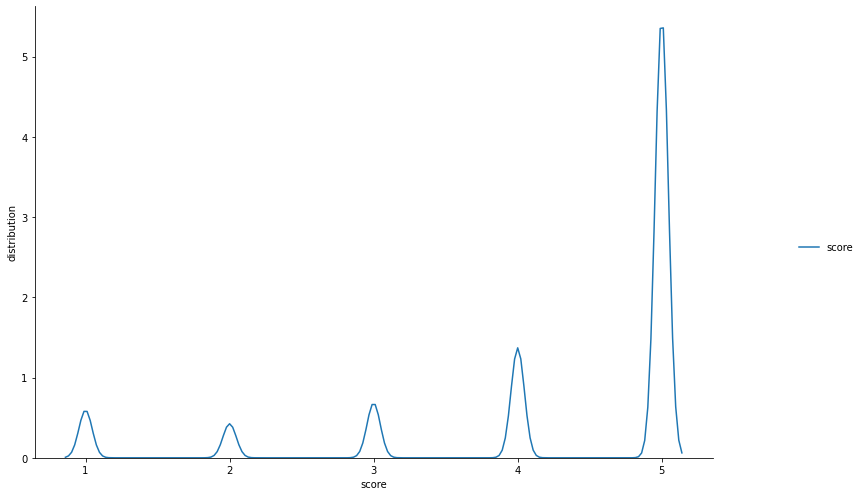

In [60]:
d = sns.displot(data = sdf, kind = "kde")
d.set_axis_labels('score', 'distribution')
d.fig.set_size_inches(12,7)
d.tight_layout()

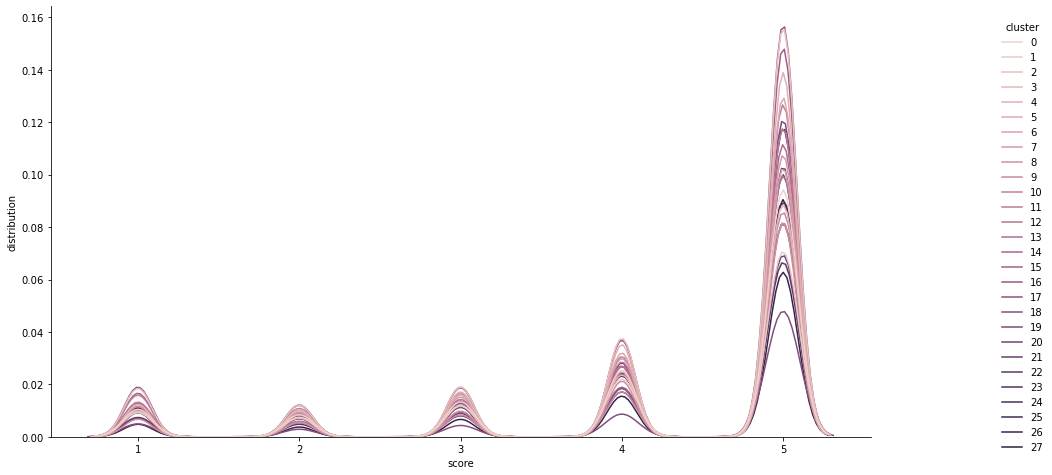

In [61]:
g = sns.displot(data = sdf, x ="score",  hue = 'cluster', kind = "kde")
g.set_axis_labels('score', 'distribution')
g.fig.set_size_inches(16,7)

Now we are look at the mean score of each cluster, and we see how the differences between them are not statistically significant, since the differences are less the the standand deviation.

In [56]:
def mean_score_for_cluster(data, num_of_cluster):
    mean_values = []
    std = []
    for i in range(num_of_cluster):
        mean_values.append(round(pd.DataFrame.mean(data[data.index == i]['score']),2))
        std.append(round(pd.DataFrame.std(data[data.index == i]['score']),2))
    return pd.DataFrame({"cluster":[j for j in range(0,num_of_cluster)], "mean score":mean_values, "standard deviation": std})

In [57]:
mean_score_for_cluster(sdf, num_of_cluster)

,cluster,mean score,standard deviation
0,0,4.21,1.23
1,1,4.13,1.26
2,2,4.24,1.24
3,3,4.24,1.22
4,4,4.30,1.16
5,5,4.28,1.18
6,6,4.30,1.17
7,7,4.23,1.21
8,8,4.32,1.14
9,9,4.30,1.22


## 2.3.4 Get the number of unique users writing reviews in each cluster

For this purpose we use again the inverted index build previously, that for each word reports the indeces (of the dataframe) of the reviews that contains the word:

for example let's see all the indeces of the word "glutenfree" 

In [30]:
inverted_index['glutenfree']

[288130,
 199971,
 19588,
 4932,
 5668,
 285859,
 41192,
 271819,
 236047,
 296656,
 74419,
 74420,
 111285,
 347379,
 348856,
 40345]

Throw this indeces we can retrieve the relativies reviews:

In [32]:
df.loc[288130,"Text"]

'The best gluten free mix I\'ve tried.  Of the recipes on the box I can vouch for the pancakes and the waffles- the biscuits were edible if not enjoyable.  The pancakes and waffles also freeze well.  I also recommend Betty Crocker\'s "Glutenfree Recipe Collection" magazine for extra recipes to try with or without this mix. From the magazine I have thus far made the chicken and dumplings (the dumplings disintegrate a bit too easily but are still good) and the fruit swirl coffee cake (I used a full can of pie filling per 8X8- I used apple and lemon pie fillings.  I thought the cake tasted rather like a cobbler or dry danish pastry).  The mix is quick, it\'s easy, it tastes good, and it is versatile.  And hey- although the packaging of the mix into the little boxes is a bit of a pain it does serve to keep the mix fresh!'

Hence, we use the inverted index in combination with another dictonary that given a number of cluster (0,1,...13) retrieves the set of the relative review.

Let's for example the indeces linked to the cluster 0:

Then we use another dictonary that given a cluster number (0, 1,... 14) retrieves the relative set of indeces.

Hence, for each word in the cluster we retrieve the reviews and get the number of unique users:

In [67]:
def number_of_unique_user(num_of_cluster,clust_reviewID):
    new_dict = {}
    for i in range(num_of_cluster):
        set_i = set()
        for review_ind in clust_reviewID[i]:
            set_i.update([df.loc[review_ind, "UserId"]])
        new_dict[i] = len(set_i)
    return new_dict

In [68]:
def view_number_of_unique_user(num_of_cluster,clust_reviewID):
    d = number_of_unique_user(num_of_cluster,clust_reviewID)
    user = pd.DataFrame.from_dict(d, orient='index', columns=['Number of unique users'])
    user = user.reset_index()
    user.columns = ['Number of Cluster','Number of unique users']
    user = user.set_index('Number of Cluster')
    return user

In [69]:
view_number_of_unique_user(num_of_cluster,clust_reviewID)

,Number of unique users
Number of Cluster,
0,208229
1,196178
2,180924
3,171015
4,145662
5,193414
6,163125
7,149983
8,181669


# 3. Algorithmic question

You are given an array with A with n integer numbers.

    Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.
    Let r = b - s

Prove that we can sort A in time O(n + r).

## Proof:

1) Defining the max and min if complexity of an array A is O(n)

    s = min(A)
    b = max(A)


2) Picking up the new array with time complexity equal to O(n)

    r = b - s    
    new_arr = new array(value=0, dim=r)
    res = new array(dim = n)
    idx = 0

3) This fragment goes through the array A n times, so its complexity is O(n) for i in 1..n:

    for i in 1..n:
        p = A[i]
        new_arr[p - s] += 1
    
    
4) This fragment goes through the array A r times, so its complexity is O (r) = O (b - s) for i in 1..r:

    if new_arr[i] != 0
        for j in 1..new_arr[i]:
            res[idx] = i + s
             idx += 1         
         return res

So the whole alghoritm complexity is :

O(n + r) = O(n + b - s)